# SHAP values for categorical features
<br>
<b>Dataset:</b> https://www.kaggle.com/datasets/uciml/mushroom-classification

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,confusion_matrix

import xgboost as xgb

import shap
shap.initjs()

path = "../shap_output/{}"

/home/horst/anaconda3/envs/load_prep_tf_gluon_data/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/horst/anaconda3/envs/load_prep_tf_gluon_data/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-ji

In [2]:
# data = pd.read_csv("../data/merged-files/merged-files-final-2022-07-06.csv")
# data = pd.read_csv("../data/merged-files/merged-files-final-2023-10-14.csv")
data = pd.read_csv("../data/merged-files/merged-files-final-2023-10-15-NaN.csv")

# Delete unnamed / index column
if set(['Unnamed: 0']).issubset(data.columns):
    data = data.drop('Unnamed: 0', axis=1)

data.head()

,extension,CR,location,working_hours,price,const_year,model,L,RR,LR,...,SA,N,H,ME,XE,LGP,XL,3B,4F,MH
0,D,0.0,FI,8973,44900,2011,308,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E2,1.0,PL,4183,49040,2016,308,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E2,1.0,PL,4655,57943,2017,308,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E2,1.0,GB,3175,45335,2015,308,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E2,1.0,GB,2500,51222,2018,308,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Featuretools

In [3]:
import featuretools as ft

from featuretools.selection import (
    remove_highly_correlated_features,
    remove_highly_null_features,
    remove_single_value_features,
)

In [4]:
es = ft.EntitySet("merged_data_frame")

In [5]:
data = data.reset_index()
data.head()

,index,extension,CR,location,working_hours,price,const_year,model,L,RR,...,SA,N,H,ME,XE,LGP,XL,3B,4F,MH
0,0,D,0.0,FI,8973,44900,2011,308,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,E2,1.0,PL,4183,49040,2016,308,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,E2,1.0,PL,4655,57943,2017,308,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,E2,1.0,GB,3175,45335,2015,308,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,E2,1.0,GB,2500,51222,2018,308,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
es.add_dataframe(dataframe_name="data",
                 index="index",
                 dataframe=data)

Entityset: merged_data_frame
  DataFrames:
    data [Rows: 2996, Columns: 23]
  Relationships:
    No relationships

Run deep feature synthesis

In [7]:
feature_matrix, features = ft.dfs(entityset = es,
                               target_dataframe_name="data")

feature_matrix

Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created


,extension,CR,location,working_hours,price,const_year,model,L,RR,LR,...,SA,N,H,ME,XE,LGP,XL,3B,4F,MH
index,,,,,,,,,,,,,,,,,,,,,
0,D,0,FI,8973,44900,2011,308,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,E2,1,PL,4183,49040,2016,308,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,E2,1,PL,4655,57943,2017,308,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,E2,1,GB,3175,45335,2015,308,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,E2,1,GB,2500,51222,2018,308,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,C,<NA>,NL,20409,35000,2005,M318,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
2992,D,<NA>,ES,21000,65000,2010,M318,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
2993,C,<NA>,IT,22406,58000,2007,M318,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1


In [8]:
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2996 entries, 0 to 2995
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   extension      2955 non-null   category
 1   CR             227 non-null    Int64   
 2   location       2996 non-null   category
 3   working_hours  2996 non-null   int64   
 4   price          2996 non-null   int64   
 5   const_year     2996 non-null   int64   
 6   model          2996 non-null   category
 7   L              1472 non-null   Int64   
 8   RR             528 non-null    Int64   
 9   LR             984 non-null    Int64   
 10  GC             984 non-null    Int64   
 11  VA             320 non-null    Int64   
 12  SA             320 non-null    Int64   
 13  N              944 non-null    Int64   
 14  H              253 non-null    Int64   
 15  ME             253 non-null    Int64   
 16  XE             316 non-null    Int64   
 17  LGP            531 non-null    In

Remove Highly Null Features with a threshold of 0.9

In [9]:
new_data = ft.selection.remove_highly_null_features(feature_matrix, pct_null_threshold=0.9)
new_data

,extension,location,working_hours,price,const_year,model,L,RR,LR,GC,VA,SA,N,XE,LGP,XL,3B,4F
index,,,,,,,,,,,,,,,,,,
0,D,FI,8973,44900,2011,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,E2,PL,4183,49040,2016,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,E2,PL,4655,57943,2017,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,E2,GB,3175,45335,2015,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,E2,GB,2500,51222,2018,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,C,NL,20409,35000,2005,M318,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2992,D,ES,21000,65000,2010,M318,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2993,C,IT,22406,58000,2007,M318,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [10]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2996 entries, 0 to 2995
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   extension      2955 non-null   category
 1   location       2996 non-null   category
 2   working_hours  2996 non-null   int64   
 3   price          2996 non-null   int64   
 4   const_year     2996 non-null   int64   
 5   model          2996 non-null   category
 6   L              1472 non-null   Int64   
 7   RR             528 non-null    Int64   
 8   LR             984 non-null    Int64   
 9   GC             984 non-null    Int64   
 10  VA             320 non-null    Int64   
 11  SA             320 non-null    Int64   
 12  N              944 non-null    Int64   
 13  XE             316 non-null    Int64   
 14  LGP            531 non-null    Int64   
 15  XL             531 non-null    Int64   
 16  3B             531 non-null    Int64   
 17  4F             531 non-null    In

### Remove Single Value Features
This is a kind of duplicate detection for features. 

Another situation we might run into is one where our calculated features don’t have any variance. In those cases, we are likely to want to remove the uninteresting features. For that, we use remove_single_value_features.

In [11]:
es = ft.EntitySet("new_data_frame")

In [12]:
es.add_dataframe(dataframe_name="new_data",
                 index="index",
                 dataframe=new_data)

index index not found in dataframe, creating new integer column


Entityset: new_data_frame
  DataFrames:
    new_data [Rows: 2996, Columns: 19]
  Relationships:
    No relationships

In [13]:
feature_matrix, features = ft.dfs(entityset = es,
                               target_dataframe_name="new_data")

feature_matrix

Only one dataframe in entityset, changing max_depth to 1 since deeper features cannot be created


,extension,location,working_hours,price,const_year,model,L,RR,LR,GC,VA,SA,N,XE,LGP,XL,3B,4F
index,,,,,,,,,,,,,,,,,,
0,D,FI,8973,44900,2011,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,E2,PL,4183,49040,2016,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,E2,PL,4655,57943,2017,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,E2,GB,3175,45335,2015,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,E2,GB,2500,51222,2018,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,C,NL,20409,35000,2005,M318,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2992,D,ES,21000,65000,2010,M318,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2993,C,IT,22406,58000,2007,M318,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [14]:
new_fm, new_features = remove_single_value_features(feature_matrix, features=features, count_nan_as_value=True)
new_fm

,extension,location,working_hours,price,const_year,model,L,RR,LR,GC,VA,SA,N,XE,LGP,XL,3B,4F
index,,,,,,,,,,,,,,,,,,
0,D,FI,8973,44900,2011,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,E2,PL,4183,49040,2016,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,E2,PL,4655,57943,2017,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,E2,GB,3175,45335,2015,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,E2,GB,2500,51222,2018,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,C,NL,20409,35000,2005,M318,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2992,D,ES,21000,65000,2010,M318,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2993,C,IT,22406,58000,2007,M318,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


Remove Highly Correlated Features

In [15]:
new_fm, new_features = remove_highly_correlated_features(
    feature_matrix, features=features, pct_corr_threshold=0.9
)
new_fm

,extension,location,working_hours,price,const_year,model,L,RR,LR,GC,VA,SA,N,XE,LGP,XL,3B,4F
index,,,,,,,,,,,,,,,,,,
0,D,FI,8973,44900,2011,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,E2,PL,4183,49040,2016,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,E2,PL,4655,57943,2017,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,E2,GB,3175,45335,2015,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,E2,GB,2500,51222,2018,308,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,C,NL,20409,35000,2005,M318,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2992,D,ES,21000,65000,2010,M318,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2993,C,IT,22406,58000,2007,M318,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


Replace NaN values by 0

In [16]:
# Get the current column names
column_names = new_fm.columns.tolist()

# Specify the names/columns with no replacement
names_to_delete = ['model', 'extension', 'location', 'working_hours', 'const_year', 'price']

# Create a list of column where the NaN values should be replaced by 0
columns_to_replace = [col for col in column_names if col not in names_to_delete]
# print(f"Column names to replace: {columns_to_replace}")

# Replace NaN values with zeros
new_fm[columns_to_replace] = new_fm[columns_to_replace].fillna(0)

new_fm


,extension,location,working_hours,price,const_year,model,L,RR,LR,GC,VA,SA,N,XE,LGP,XL,3B,4F
index,,,,,,,,,,,,,,,,,,
0,D,FI,8973,44900,2011,308,0,0,0,0,0,0,0,0,0,0,0,0
1,E2,PL,4183,49040,2016,308,0,0,0,0,0,0,0,0,0,0,0,0
2,E2,PL,4655,57943,2017,308,0,0,0,0,0,0,0,0,0,0,0,0
3,E2,GB,3175,45335,2015,308,0,0,0,0,0,0,0,0,0,0,0,0
4,E2,GB,2500,51222,2018,308,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,C,NL,20409,35000,2005,M318,0,0,0,0,0,0,0,0,0,0,0,0
2992,D,ES,21000,65000,2010,M318,0,0,0,0,0,0,0,0,0,0,0,0
2993,C,IT,22406,58000,2007,M318,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
new_fm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2996 entries, 0 to 2995
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   extension      2955 non-null   category
 1   location       2996 non-null   category
 2   working_hours  2996 non-null   int64   
 3   price          2996 non-null   int64   
 4   const_year     2996 non-null   int64   
 5   model          2996 non-null   category
 6   L              2996 non-null   Int64   
 7   RR             2996 non-null   Int64   
 8   LR             2996 non-null   Int64   
 9   GC             2996 non-null   Int64   
 10  VA             2996 non-null   Int64   
 11  SA             2996 non-null   Int64   
 12  N              2996 non-null   Int64   
 13  XE             2996 non-null   Int64   
 14  LGP            2996 non-null   Int64   
 15  XL             2996 non-null   Int64   
 16  3B             2996 non-null   Int64   
 17  4F             2996 non-null   In

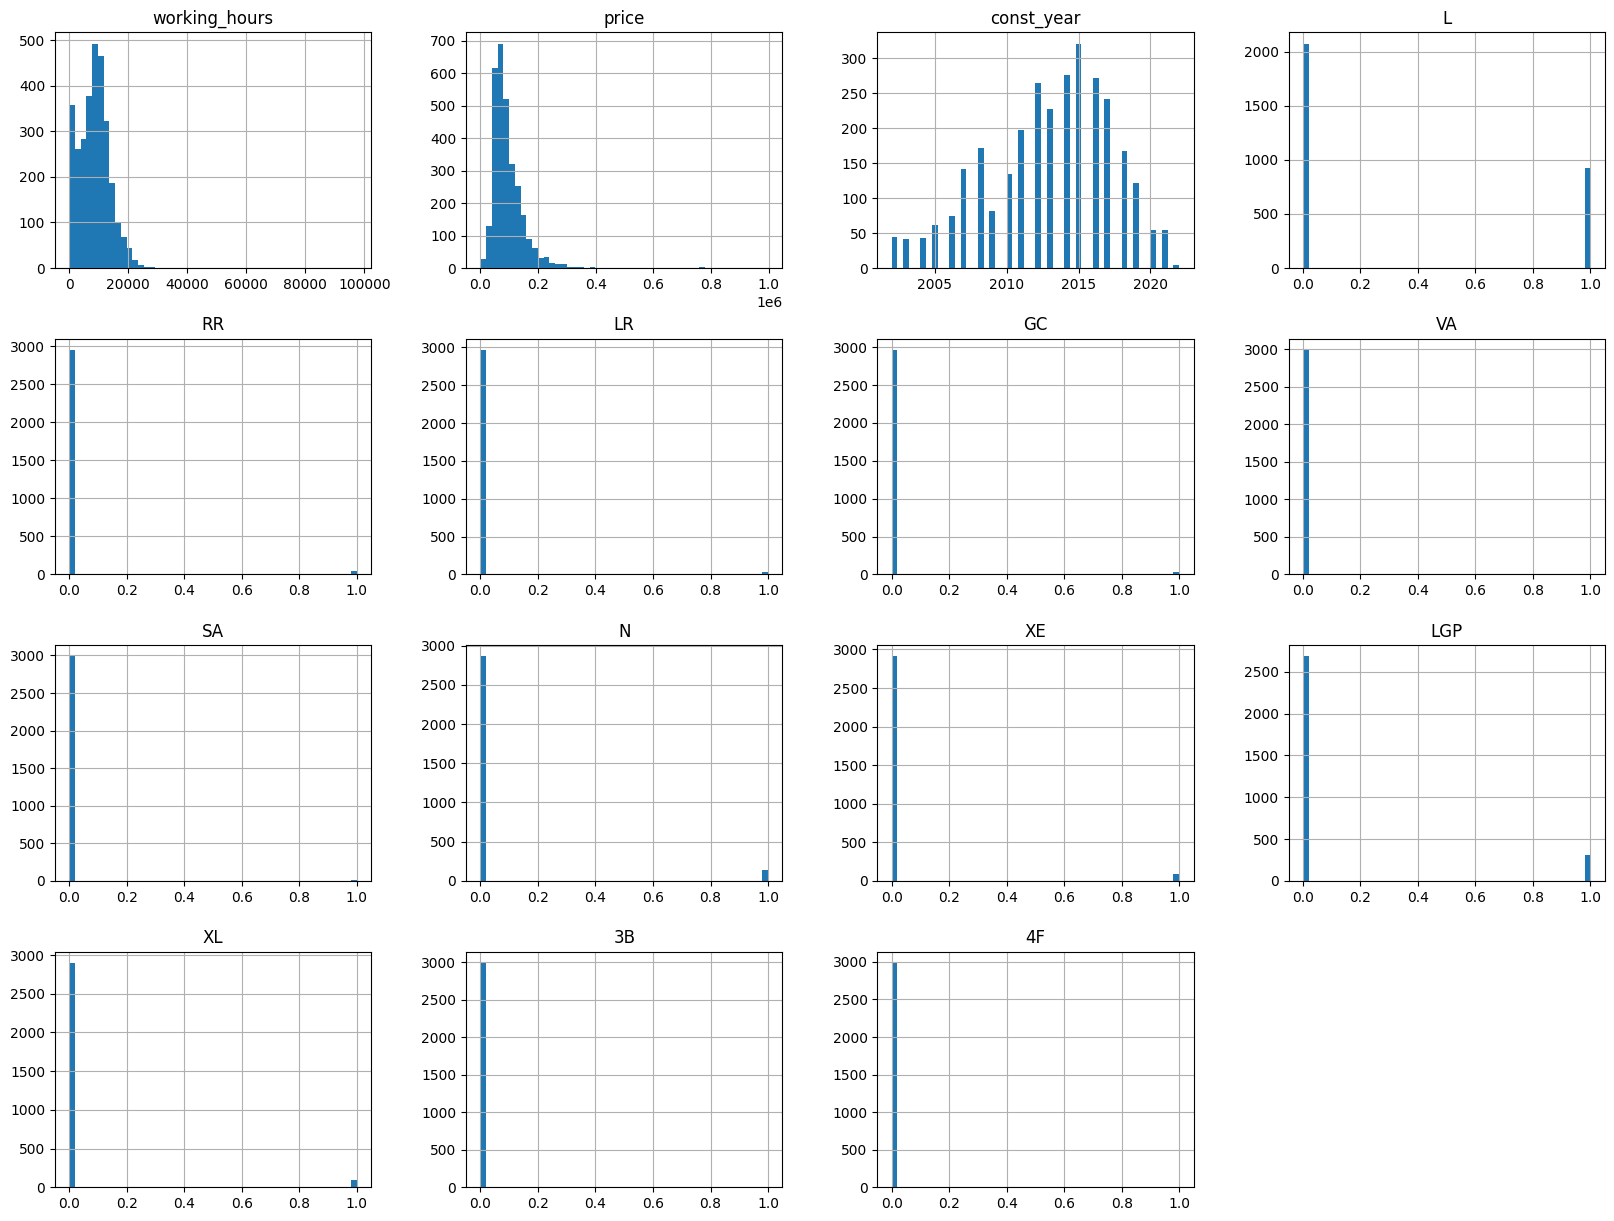

In [18]:
new_fm.hist(bins=50, figsize=(20,15))
plt.show()

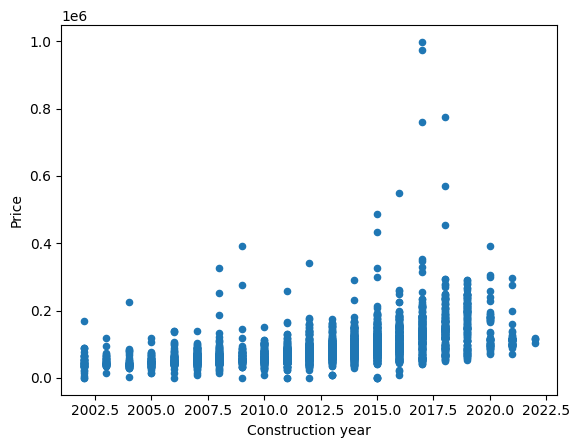

In [19]:
new_fm.plot(kind='scatter', x = 'const_year', y = 'price')
# Set labels for x and y axes
plt.xlabel('Construction year')
plt.ylabel('Price')

# # Save the plot as a PDF file
# filename = "{}-{}.{}".format(DATASET,'price-constr-year-plot','pdf')
# filepath = Path(MEASUREMENT_PATH, filename)
# plt.savefig(filepath, format='pdf', bbox_inches='tight')

plt.show()

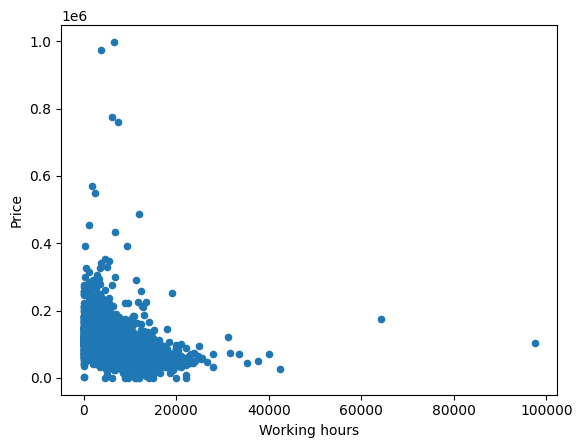

In [20]:
new_fm.plot(kind='scatter', x = 'working_hours', y = 'price')
# Set labels for x and y axes
plt.xlabel('Working hours')
plt.ylabel('Price')

# # Save the plot as a PDF file
# filename = "{}-{}.{}".format(DATASET,'price-working-houers-plot','pdf')
# filepath = Path(MEASUREMENT_PATH, filename)
# plt.savefig(filepath, format='pdf', bbox_inches='tight')

plt.show()

Use Autogluon for anomaly / outlier detection

In [21]:
import seaborn as sns

import autogluon.eda.auto as auto

In [22]:
new_fm

,extension,location,working_hours,price,const_year,model,L,RR,LR,GC,VA,SA,N,XE,LGP,XL,3B,4F
index,,,,,,,,,,,,,,,,,,
0,D,FI,8973,44900,2011,308,0,0,0,0,0,0,0,0,0,0,0,0
1,E2,PL,4183,49040,2016,308,0,0,0,0,0,0,0,0,0,0,0,0
2,E2,PL,4655,57943,2017,308,0,0,0,0,0,0,0,0,0,0,0,0
3,E2,GB,3175,45335,2015,308,0,0,0,0,0,0,0,0,0,0,0,0
4,E2,GB,2500,51222,2018,308,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,C,NL,20409,35000,2005,M318,0,0,0,0,0,0,0,0,0,0,0,0
2992,D,ES,21000,65000,2010,M318,0,0,0,0,0,0,0,0,0,0,0,0
2993,C,IT,22406,58000,2007,M318,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
# new_fm = new_fm.reset_index(drop=True)

Convert all int64 values to float

In [24]:
# Drop rows with NaN values
new_fm = new_fm.dropna()

In [25]:
new_fm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2955 entries, 0 to 2995
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   extension      2955 non-null   category
 1   location       2955 non-null   category
 2   working_hours  2955 non-null   int64   
 3   price          2955 non-null   int64   
 4   const_year     2955 non-null   int64   
 5   model          2955 non-null   category
 6   L              2955 non-null   Int64   
 7   RR             2955 non-null   Int64   
 8   LR             2955 non-null   Int64   
 9   GC             2955 non-null   Int64   
 10  VA             2955 non-null   Int64   
 11  SA             2955 non-null   Int64   
 12  N              2955 non-null   Int64   
 13  XE             2955 non-null   Int64   
 14  LGP            2955 non-null   Int64   
 15  XL             2955 non-null   Int64   
 16  3B             2955 non-null   Int64   
 17  4F             2955 non-null   In

In [26]:
column_names = new_fm.columns.tolist()
column_names

['extension',
 'location',
 'working_hours',
 'price',
 'const_year',
 'model',
 'L',
 'RR',
 'LR',
 'GC',
 'VA',
 'SA',
 'N',
 'XE',
 'LGP',
 'XL',
 '3B',
 '4F']

In [27]:
# Get the current column names
# column_names = new_fm.columns.tolist()

# Specify the names/columns with no replacement
categorical_features = ['model', 'extension', 'location']

# Create a list of column where the NaN values should be replaced by 0
columns_to_replace = [col for col in column_names if col not in categorical_features]
# print(f"Column names to replace: {columns_to_replace}")

new_fm[columns_to_replace] = new_fm[columns_to_replace].astype(float)

# Replace NaN values with zeros
# new_fm[columns_to_replace] = new_fm[columns_to_replace].fillna(0)

new_fm.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2955 entries, 0 to 2995
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   extension      2955 non-null   category
 1   location       2955 non-null   category
 2   working_hours  2955 non-null   float64 
 3   price          2955 non-null   float64 
 4   const_year     2955 non-null   float64 
 5   model          2955 non-null   category
 6   L              2955 non-null   float64 
 7   RR             2955 non-null   float64 
 8   LR             2955 non-null   float64 
 9   GC             2955 non-null   float64 
 10  VA             2955 non-null   float64 
 11  SA             2955 non-null   float64 
 12  N              2955 non-null   float64 
 13  XE             2955 non-null   float64 
 14  LGP            2955 non-null   float64 
 15  XL             2955 non-null   float64 
 16  3B             2955 non-null   float64 
 17  4F             2955 non-null   fl

In [28]:
new_fm

,extension,location,working_hours,price,const_year,model,L,RR,LR,GC,VA,SA,N,XE,LGP,XL,3B,4F
index,,,,,,,,,,,,,,,,,,
0,D,FI,8973.0,44900.0,2011.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E2,PL,4183.0,49040.0,2016.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E2,PL,4655.0,57943.0,2017.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E2,GB,3175.0,45335.0,2015.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,E2,GB,2500.0,51222.0,2018.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2991,C,NL,20409.0,35000.0,2005.0,M318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2992,D,ES,21000.0,65000.0,2010.0,M318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2993,C,IT,22406.0,58000.0,2007.0,M318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
from sklearn.model_selection import train_test_split

# Split the data into training and test set
X_train, X_test = train_test_split(new_fm, test_size=0.2, random_state=42)
# df_dataset_X_train = df_dataset_train.drop(LABEL, axis = 1)
# df_dataset_y_train = df_dataset_train[LABEL].copy()
# df_dataset_X_test = df_dataset_test.drop(LABEL, axis = 1)
# df_dataset_y_test = df_dataset_test[LABEL].copy()

In [30]:
# This parameter specifies how many standard deviations above mean anomaly score are considered
# to be anomalies (only needed for visualization, does not affect scores calculation).
threshold_stds = 3

### Anomaly Detection Report

When interpreting anomaly scores, consider:
* **Threshold**: Determine a suitable threshold to separate normal from anomalous data points,     based on domain knowledge or statistical methods.
* **Context**: Examine the context of anomalies, including time, location, and surrounding data points, to identify possible causes.
* **False positives/negatives**: Be aware of the trade-offs between false positives (normal points classified as anomalies)     and false negatives (anomalies missed).
* **Feature relevance**: Ensure the features used for anomaly detection are relevant and contribute to the model's performance.
* **Model performance**: Regularly evaluate and update the model to maintain its accuracy and effectiveness.

It's important to understand the context and domain knowledge before deciding on an appropriate approach to deal with anomalies.The choice of method depends on the data's nature, the cause of anomalies, and the problem being addressed.The common ways to deal with anomalies:

* **Removal**: If an anomaly is a result of an error, noise, or irrelevance to the analysis, it can be removed from the dataset     to prevent it from affecting the model's performance.
* **Imputation**: Replace anomalous values with appropriate substitutes, such as the mean, median, or mode of the feature,    or by using more advanced techniques like regression or k-nearest neighbors.
* **Transformation**: Apply transformations like log, square root, or z-score to normalize the data and reduce the impact of extreme values.
    Absolute dates might be transformed into relative features like age of the item.
* **Capping**: Set upper and lower bounds for a feature, and replace values outside these limits with the bounds themselves.    This method is also known as winsorizing.
* **Separate modeling**: Treat anomalies as a distinct group and build a separate model for them, or use specialized algorithms designed    for handling outliers, such as robust regression or one-class SVM.
* **Incorporate as a feature**: Create a new binary feature indicating the presence of an anomaly,     which can be useful if anomalies have predictive value.

<sub><sup>Use `show_help_text=False` to hide this information when calling this function.</sup></sub>

**`train_data` anomalies for 3-sigma outlier scores**

**`test_data` anomalies for 3-sigma outlier scores**

**Top-10 `train_data` anomalies (total: 18)**

,extension,location,working_hours,price,const_year,model,L,RR,LR,GC,VA,SA,N,XE,LGP,XL,3B,4F,score
index,,,,,,,,,,,,,,,,,,,
2658,R,IT,97458.0,105000.0,2006.0,D6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.949073
326,NG,DE,246.0,134500.0,2020.0,320,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.648440
264,NG,DE,249.0,180500.0,2020.0,320,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.557524
303,NG,BE,321.0,175000.0,2020.0,320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.773869
1709,M,NL,300.0,178000.0,2020.0,950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.760951
92,E2,BE,315.0,99000.0,2019.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.747857
1561,NG,BE,305.0,299000.0,2020.0,336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.707819
365,NG,DE,398.0,159000.0,2021.0,320,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.699253
2623,R,RU,42500.0,26978.0,2007.0,D6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.277210


⚠️ Please note that the feature values shown on the charts below are transformed into an internal representation; they may be encoded or modified based on internal preprocessing. Refer to the original datasets for the actual feature values.

⚠️ The detector has seen this dataset; the may result in overly optimistic estimates. Although the anomaly score in the explanation might not match, the magnitude of the feature scores can still be utilized to evaluate the impact of the feature on the anomaly score.

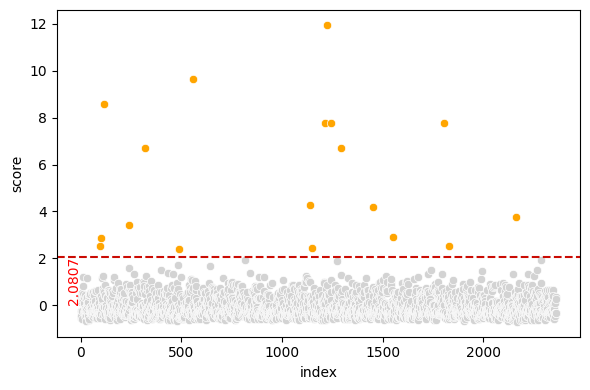

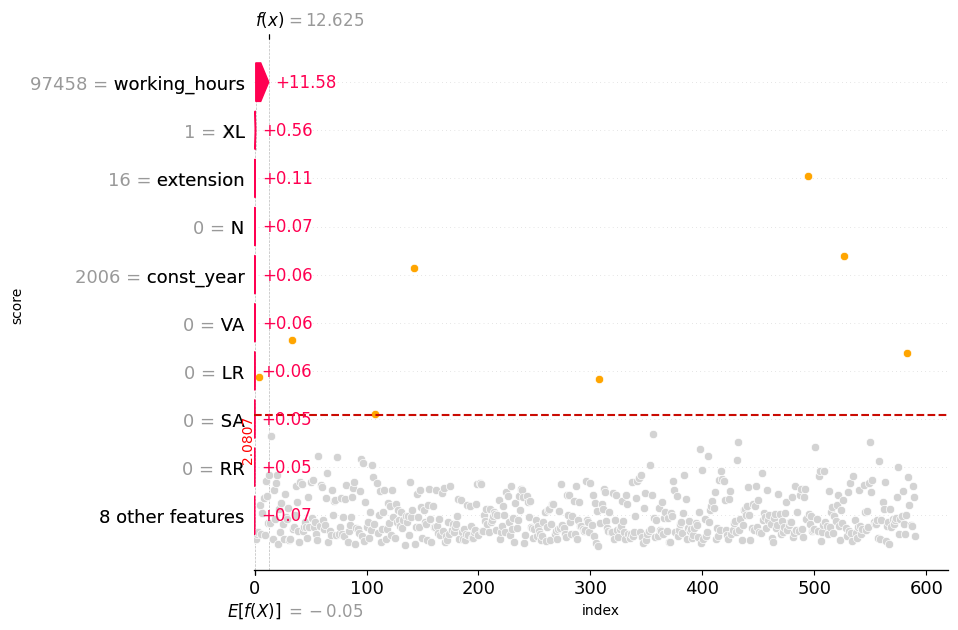

**Top-10 `test_data` anomalies (total: 8)**

,extension,location,working_hours,price,const_year,model,L,RR,LR,GC,VA,SA,N,XE,LGP,XL,3B,4F,score
index,,,,,,,,,,,,,,,,,,,
499,NG,GE,268.0,170790.0,2020.0,320,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.055586
2585,T,NO,320.0,391188.0,2020.0,D6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.382862
214,E2,PL,310.0,66000.0,2018.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.145799
2054,H,TR,40000.0,70000.0,2008.0,966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.632792
955,D,PL,380.0,61470.0,2010.0,323,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.366991
2995,D,PL,35194.0,45120.0,2011.0,M318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.878569
2137,H,BE,398.0,209000.0,2015.0,966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.832164
73,E2,DE,447.0,84200.0,2019.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.098989


⚠️ Please note that the feature values shown on the charts below are transformed into an internal representation; they may be encoded or modified based on internal preprocessing. Refer to the original datasets for the actual feature values.

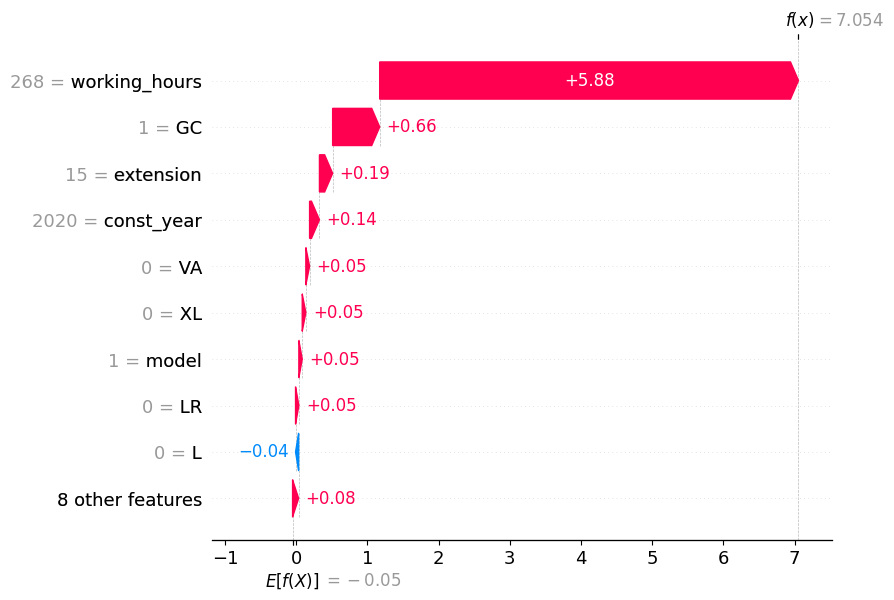

In [31]:
target_col = 'price'

state = auto.detect_anomalies(
    train_data= X_train,
    test_data=X_test,
    label=target_col,
    threshold_stds=threshold_stds,
    bps_flag=False,
    return_state=True,
    # show_top_n_anomalies=None,
    # show_top_n_anomalies=10,
    explain_top_n_anomalies=1,
    fig_args={
        'figsize': (6, 4)
    },
    chart_args={
        'normal.color': 'lightgrey',
        'anomaly.color': 'orange',
    }
)

In [32]:
print(state)

{'problem_type': 'regression', 'anomaly_detection': {'scores': {'train_data': index
1392   -0.238999
1764   -0.523583
905     0.147473
2355    0.393504
2904   -0.461967
          ...   
1667    0.084404
1122    0.355388
1157   -0.316806
1322    0.264774
886    -0.312034
Name: score, Length: 2364, dtype: float64, 'test_data': index
1775   -0.499144
2808   -0.484825
184    -0.380449
2886   -0.343272
2995    2.878569
          ...   
2919   -0.193763
595    -0.216795
2517    0.599564
2152    0.379831
1117   -0.427230
Name: score, Length: 591, dtype: float64}, 'explain_rows_fns': {'train_data': functools.partial(<function AnomalyDetectorAnalysis.explain_rows_fn at 0x7f954da19510>, {'train_data':        working_hours  const_year  L  RR  LR  GC  VA  SA  N  XE  LGP  XL  3B  \
index                                                                         
1392          9027.0      2007.0  1   0   0   0   0   0  0   0    0   0   0   
1764          5950.0      2017.0  0   0   0   0   0   0  0   0

In [33]:
train_anomaly_scores = state.anomaly_detection.scores.train_data

In [34]:
test_anomaly_scores = state.anomaly_detection.scores.test_data

In [35]:
train_anomaly = state.anomaly_detection.anomalies.train_data
train_anomaly

,extension,location,working_hours,price,const_year,model,L,RR,LR,GC,VA,SA,N,XE,LGP,XL,3B,4F,score
index,,,,,,,,,,,,,,,,,,,
2658,R,IT,97458.0,105000.0,2006.0,D6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.949073
326,NG,DE,246.0,134500.0,2020.0,320,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.648440
264,NG,DE,249.0,180500.0,2020.0,320,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.557524
303,NG,BE,321.0,175000.0,2020.0,320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.773869
1709,M,NL,300.0,178000.0,2020.0,950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.760951
92,E2,BE,315.0,99000.0,2019.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.747857
1561,NG,BE,305.0,299000.0,2020.0,336,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.707819
365,NG,DE,398.0,159000.0,2021.0,320,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.699253
2623,R,RU,42500.0,26978.0,2007.0,D6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.277210


In [36]:
test_anomaly = state.anomaly_detection.anomalies.test_data
test_anomaly

,extension,location,working_hours,price,const_year,model,L,RR,LR,GC,VA,SA,N,XE,LGP,XL,3B,4F,score
index,,,,,,,,,,,,,,,,,,,
499,NG,GE,268.0,170790.0,2020.0,320,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.055586
2585,T,NO,320.0,391188.0,2020.0,D6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.382862
214,E2,PL,310.0,66000.0,2018.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.145799
2054,H,TR,40000.0,70000.0,2008.0,966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.632792
955,D,PL,380.0,61470.0,2010.0,323,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.366991
2995,D,PL,35194.0,45120.0,2011.0,M318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.878569
2137,H,BE,398.0,209000.0,2015.0,966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.832164
73,E2,DE,447.0,84200.0,2019.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.098989


In [37]:
test_indeces = test_anomaly.index.values
print(test_indeces)
data1 = new_fm.drop(test_indeces)
train_indices = train_anomaly.index.values
print(train_indices)
data = data1.drop(train_indices)
data

[ 499 2585  214 2054  955 2995 2137   73]
[2658  326  264  303 1709   92 1561  365 2623 1668 2189   53 2343 1031
 2846 2185 1990  304]


,extension,location,working_hours,price,const_year,model,L,RR,LR,GC,VA,SA,N,XE,LGP,XL,3B,4F
index,,,,,,,,,,,,,,,,,,
0,D,FI,8973.0,44900.0,2011.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E2,PL,4183.0,49040.0,2016.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E2,PL,4655.0,57943.0,2017.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E2,GB,3175.0,45335.0,2015.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,E2,GB,2500.0,51222.0,2018.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2990,D,ES,20000.0,86000.0,2010.0,M318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2991,C,NL,20409.0,35000.0,2005.0,M318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2992,D,ES,21000.0,65000.0,2010.0,M318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
#get features
y = data['price']
print(y.head())

X_cat = data.drop('price', axis=1)


print(len(X_cat))
X_cat.head()

index
0    44900.0
1    49040.0
2    57943.0
3    45335.0
4    51222.0
Name: price, dtype: float64
2929


,extension,location,working_hours,const_year,model,L,RR,LR,GC,VA,SA,N,XE,LGP,XL,3B,4F
index,,,,,,,,,,,,,,,,,
0,D,FI,8973.0,2011.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,E2,PL,4183.0,2016.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,E2,PL,4655.0,2017.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,E2,GB,3175.0,2015.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,E2,GB,2500.0,2018.0,308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
#fit encoder
enc = OneHotEncoder()
enc.fit(X_cat)

#transform categorical features
X_encoded = enc.transform(X_cat).toarray()

#create feature matrix
feature_names = X_cat.columns
new_feature_names = enc.get_feature_names_out(feature_names)

X = pd.DataFrame(X_encoded, columns= new_feature_names)

X

,extension_B,extension_C,extension_D,extension_D2,extension_D3,extension_E,extension_E2,extension_F,extension_G,extension_GC,...,XE_0.0,XE_1.0,LGP_0.0,LGP_1.0,XL_0.0,XL_1.0,3B_0.0,3B_1.0,4F_0.0,4F_1.0
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2924,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2925,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2926,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2927,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [40]:
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
#Train model
# model = xgb.XGBClassifier(objective="binary:logistic", 
#                          max_depth=2, 
#                         n_estimators=10)

model = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)


model.fit(X, y)

#Get predictions
y_pred = model.predict(X)

# print(confusion_matrix(y, y_pred))
# accuracy_score(y, y_pred)

#Get predictions
print(mean_absolute_percentage_error(y, y_pred))

100.20530536130747


# Standard SHAP values

In [41]:
# get shap values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# waterfall plot
shap.plots.waterfall(shap_values[1], show=False)
# plt.figure()
plt.savefig(path.format('standard_shap.png'),dpi=100,bbox_inches='tight')

# SHAP for catgeorical features 

In [42]:
print(shap_values)

.values =
array([[    0.       ,   143.9117   , -2404.5002   , ...,     0.       ,
            0.       ,     0.       ],
       [    0.       ,   334.77832  ,   879.9811   , ...,     0.       ,
            0.       ,     0.       ],
       [    0.       ,   152.79997  ,   397.3412   , ...,     0.       ,
            0.       ,     0.       ],
       ...,
       [    0.       ,   169.49947  , -2873.6985   , ...,     0.       ,
            0.       ,     0.       ],
       [    0.       , -6102.8457   ,     7.3993807, ...,     0.       ,
            0.       ,     0.       ],
       [    0.       ,   170.80415  , -2933.971    , ...,     0.       ,
            0.       ,     0.       ]], dtype=float32)

.base_values =
array([58192.656, 58192.656, 58192.656, ..., 58192.656, 58192.656,
       58192.656], dtype=float32)

.data =
array([[0., 0., 1., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 1., 0.],


In [43]:
print(shap_values.values[1])

[  0.      334.77832 879.9811  ...   0.        0.        0.     ]


In [44]:
#get number of unique categories for each feature 
n_categories = []
for feat in feature_names[:-1]:
    n = X_cat[feat].nunique()
    n_categories.append(n)
    
n_categories

[19, 35, 2051, 21, 10, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

In [45]:
new_shap_values = []
for values in shap_values.values:
    
    #split shap values into a list for each feature
    values_split = np.split(values , np.cumsum(n_categories))
    
    #sum values within each list
    values_sum = [sum(l) for l in values_split]
    
    new_shap_values.append(values_sum)


print(len(new_shap_values),sum(new_shap_values[1]),sum(shap_values.values[1]))
print(new_shap_values[1])

2929 -24122.26667233347 -24122.26667233347
[-2183.4840752780437, -557.9972570296377, -164.7041846883949, 2522.364582762122, -23677.50994414091, 44.919769287109375, 0.0, -0.09186705201864243, 1.205475091934204, 0.0, 0.0, -37.84774398803711, 6.947976112365723, -74.22370147705078, 0.0, -1.8457019329071045, 0.0]


In [46]:
#replace shap values
shap_values.values = np.array(new_shap_values)

#replace data with categorical feature values 
new_data = np.array(X_cat)
shap_values.data = np.array(new_data)
# print(shap_values)

#update feature names
shap_values.feature_names = list(X_cat.columns)
print(shap_values)
print(shap_values.feature_names)

.values =
array([[-5.84301292e+03, -1.05692387e+02, -8.64292338e+01, ...,
         0.00000000e+00, -2.96692061e+00,  0.00000000e+00],
       [-2.18348408e+03, -5.57997257e+02, -1.64704185e+02, ...,
         0.00000000e+00, -1.84570193e+00,  0.00000000e+00],
       [-1.59162031e+03, -7.35398868e+02, -1.12523689e+03, ...,
         0.00000000e+00, -1.87107432e+00,  0.00000000e+00],
       ...,
       [-5.57836493e+03, -6.39694635e+00, -1.06139286e+02, ...,
         0.00000000e+00, -2.96692061e+00,  0.00000000e+00],
       [-9.27008926e+03, -3.56265331e+01, -1.79367455e+02, ...,
         0.00000000e+00, -2.96692061e+00,  0.00000000e+00],
       [-5.47035611e+03, -6.80809288e+02, -1.20491623e+02, ...,
         0.00000000e+00, -3.18602300e+00,  0.00000000e+00]])

.base_values =
array([58192.656, 58192.656, 58192.656, ..., 58192.656, 58192.656,
       58192.656], dtype=float32)

.data =
array([['D', 'FI', 8973.0, ..., 0.0, 0.0, 0.0],
       ['E2', 'PL', 4183.0, ..., 0.0, 0.0, 0.0],
       ['E

In [47]:
print(shap_values[1])

.values =
array([-2.18348408e+03, -5.57997257e+02, -1.64704185e+02,  2.52236458e+03,
       -2.36775099e+04,  4.49197693e+01,  0.00000000e+00, -9.18670520e-02,
        1.20547509e+00,  0.00000000e+00,  0.00000000e+00, -3.78477440e+01,
        6.94797611e+00, -7.42237015e+01,  0.00000000e+00, -1.84570193e+00,
        0.00000000e+00])

.base_values =
58192.656

.data =
array(['E2', 'PL', 4183.0, 2016.0, '308', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=object)


In [48]:
vals = np.abs(shap_values.values).mean(0)
vals

array([4.56254322e+03, 7.90078711e+02, 7.10040244e+02, 1.27575960e+04,
       5.28833501e+03, 5.50243001e+01, 0.00000000e+00, 5.94813725e-01,
       3.55215270e+00, 0.00000000e+00, 0.00000000e+00, 3.85056058e+01,
       2.76691766e+01, 2.10219939e+02, 0.00000000e+00, 7.44926369e+00,
       0.00000000e+00])

In [49]:
perc_vals = vals / sum(vals)
perc_vals

array([1.86594810e-01, 3.23119321e-02, 2.90385905e-02, 5.21748744e-01,
       2.16277593e-01, 2.25033459e-03, 0.00000000e+00, 2.43261595e-05,
       1.45272763e-04, 0.00000000e+00, 0.00000000e+00, 1.57476781e-03,
       1.13158922e-03, 8.59738696e-03, 0.00000000e+00, 3.04653321e-04,
       0.00000000e+00])

In [50]:
feature_importance = pd.DataFrame(list(zip(feature_names, vals, perc_vals)), columns=['feature_name','feature_importance_vals','feature_importance_percentage'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
filename = "{}{}{}{}.{}".format('../measurements/summary/', '2023-11-17', '/', 'feature-importance', 'csv')
feature_importance.to_csv(filename, index=False)
feature_importance.head(20)

,feature_name,feature_importance_vals,feature_importance_percentage
3,const_year,12757.595965,0.521749
4,model,5288.335009,0.216278
0,extension,4562.543219,0.186595
1,location,790.078711,0.032312
2,working_hours,710.040244,0.029039
13,LGP,210.219939,0.008597
5,L,55.024300,0.002250
11,N,38.505606,0.001575
12,XE,27.669177,0.001132
15,3B,7.449264,0.000305


In [51]:
# Get values from column 'A' where values in column 'B' are greater than the threshold
selected_values = feature_importance.loc[feature_importance['feature_importance_percentage'] > 0.01, 'feature_name']
selected_values

3       const_year
4            model
0        extension
1         location
2    working_hours
Name: feature_name, dtype: object

In [52]:
type(selected_values)

pandas.core.series.Series

In [53]:
selectetd_data = data[selected_values].copy()

In [54]:
selectetd_data

,const_year,model,extension,location,working_hours
index,,,,,
0,2011.0,308,D,FI,8973.0
1,2016.0,308,E2,PL,4183.0
2,2017.0,308,E2,PL,4655.0
3,2015.0,308,E2,GB,3175.0
4,2018.0,308,E2,GB,2500.0
...,...,...,...,...,...
2990,2010.0,M318,D,ES,20000.0
2991,2005.0,M318,C,NL,20409.0
2992,2010.0,M318,D,ES,21000.0


In [55]:
# feature_importance = feature_importance.drop(['feature_importance_vals'], axis=1)

In [56]:
# Sort the DataFrame by the 'Values' column in descending order
# feature_importance = feature_importance.sort_values(by='feature_importance_percentage', ascending=False)
feature_importance.sort_values('feature_importance_percentage', inplace=True, ascending=True)
feature_importance.head(20)

,feature_name,feature_importance_vals,feature_importance_percentage
16,4F,0.000000,0.000000
14,XL,0.000000,0.000000
9,VA,0.000000,0.000000
10,SA,0.000000,0.000000
6,RR,0.000000,0.000000
7,LR,0.594814,0.000024
8,GC,3.552153,0.000145
15,3B,7.449264,0.000305
12,XE,27.669177,0.001132
11,N,38.505606,0.001575


In [57]:
# Plotting
plt.figure()
plt.barh(feature_importance['feature_name'], feature_importance['feature_importance_percentage'],  color='r')
# feature_importance.plot(kind='barh',y='faeture_name', x='feature_importance_percentage', color='r')

# Adding labels and title
plt.xlabel('Feature importance in %')
plt.ylabel('Features')
plt.title('Feature importance')

plt.savefig(path.format('boxplot_rd_3.png'),dpi=100,bbox_inches='tight')

# Display the plot
# plt.show()

In [58]:
# waterfall plot
plt.figure()
shap.plots.waterfall(shap_values[1], show=False)

plt.savefig(path.format('category_shap_rd.png'),dpi=100,bbox_inches='tight')

In [59]:
#Mean SHAP
plt.figure()
shap.plots.bar(shap_values,show=False)

plt.savefig(path.format('mean_shap_rd.png'),dpi=100,bbox_inches='tight')

In [60]:
plt.figure()
shap.plots.beeswarm(shap_values ,show=False)

plt.savefig(path.format('beeswarm_rd.png'),dpi=100,bbox_inches='tight')

In [61]:
#get shaply values and data
model_values = shap_values[:,"model"].values
model_data = shap_values[:,"model"].data


#split odor shap values based on odor category
model_categories = list(set(model_data))

model_groups = []
for o in model_categories:
    relevant_values = model_values[model_data == o]
    model_groups.append(relevant_values)
    
#replace categories with labels
model_labels = {'1':'308',
               '2':'320', 
               '3':'323', 
               '4':'329', 
               '5':'330', 
               '6':'336', 
               '7':'950', 
               '8':'966',
               '9':'D6', 
               '10':'M318'}

labels = [model_labels[u] for u in model_labels]

#plot boxplot
plt.figure(figsize=(8, 5))

plt.boxplot(model_groups,labels=labels)

plt.ylabel('Shap values',size=15)
plt.xlabel('Odor',size=15)

plt.savefig(path.format('boxplot_rd.png'),dpi=100,bbox_inches='tight')